In [1]:
# библиотеки
import numpy as np
import pandas as pd
#import datetime
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import math
import scipy.stats as stats
import warnings


from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import VECM 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from scipy.stats.mstats import gmean
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

from datetime import datetime

In [2]:
# источники

'''
https://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
http://www.cbr.ru/statistics/idkp_br/
'''

'\nhttps://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/\nhttps://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/\nhttps://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/\nhttp://www.cbr.ru/statistics/idkp_br/\n'

In [3]:
# формируем датасет

data = pd.read_excel(r'C:\Users\Nikolay\Google Диск\9 семестр\НИР\dataset.xlsx', 'LIKV2', parse_dates=True, dayfirst=True, index_col= 0, names=['Date', 'Nal','Ost','Rez'])
# names=['Дата', 'Изменение наличных денег в обращении','Изменение остатков средств на счетах РП','Регулирование ЦБР обязательных резервов']

C:\Programs\Anaconda\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


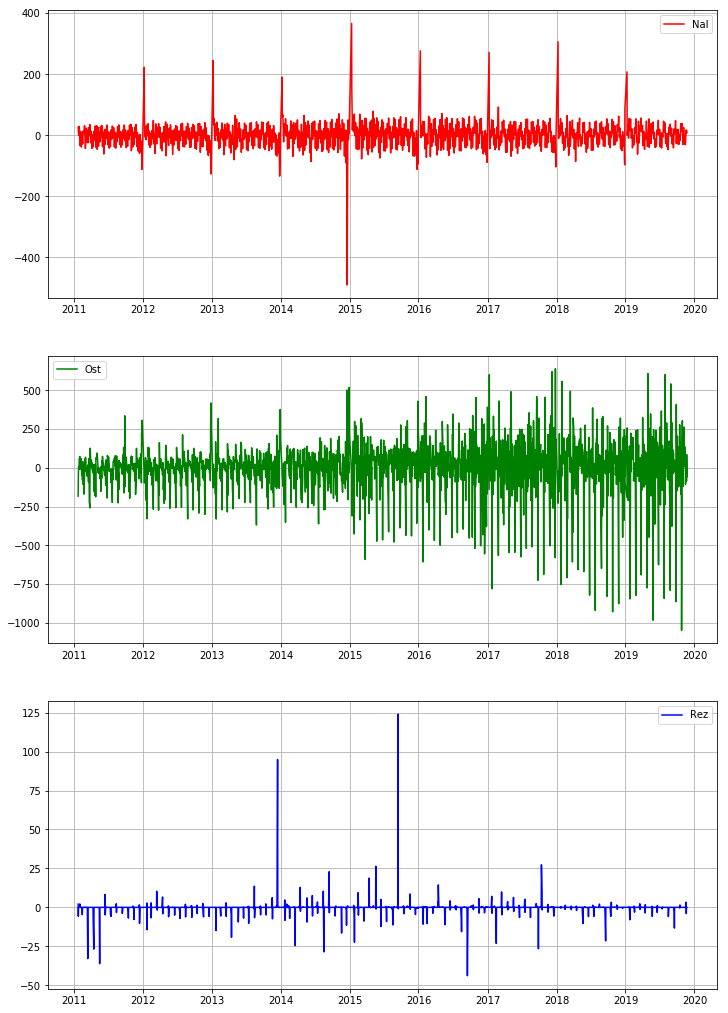

In [4]:
# смотрим графики

fig = plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
fig = plt.plot(data['Nal'], label="Nal", marker='', c='r')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
fig = plt.plot(data['Ost'], label="Ost", marker='', c='g')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
fig = plt.plot(data['Rez'], label="Rez", marker='', c='b')
plt.legend()
plt.grid(True)

plt.show()

In [5]:
# Выделяем в отдельные серии каждый из признаков ВР
nal = data.Nal
ost = data.Ost
rez = data.Rez
nal.head()

Date
2011-01-25    25.58
2011-01-26    15.06
2011-01-27     2.88
2011-01-28    -1.00
2011-01-31    29.18
Name: Nal, dtype: float64

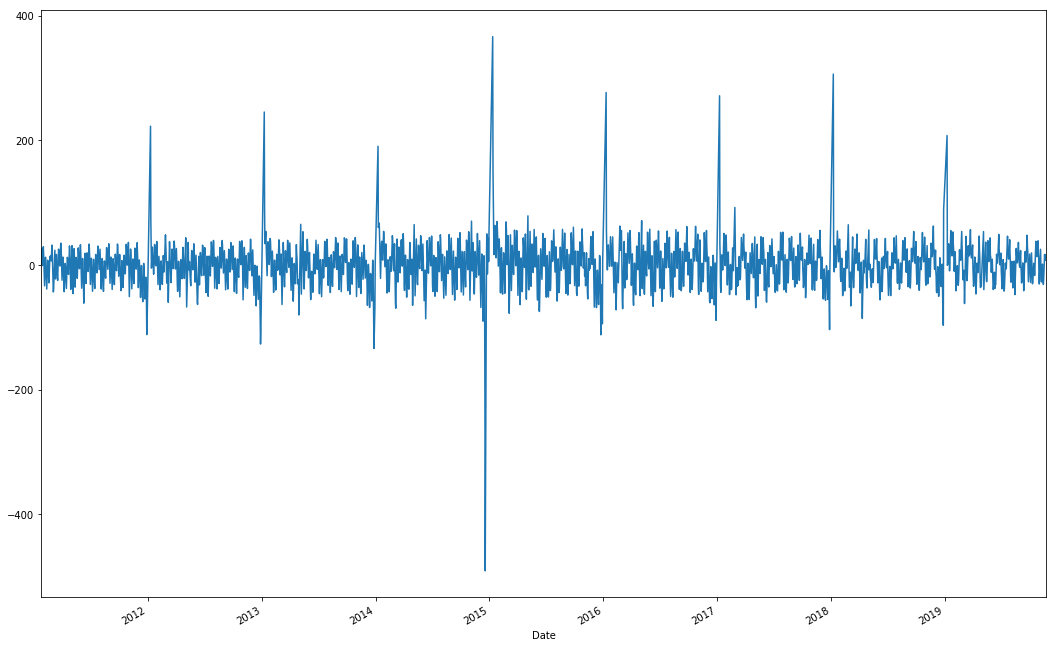

In [6]:
# график ряда
nal.plot(figsize=(18,12))

# вывод: есть выбросы, наблюдается сезонность

In [7]:
data_nal = data.copy()
data_nal.drop(['Ost','Rez'], axis=1, inplace=True)
#data_nal

In [8]:
# определяем тестовые данные

trn_start,trn_end = '2011-01-11','2019-11-15'
tst_start,tst_end = '2019-11-18','2019-11-22'
trn = nal[:'2019-11-15']
tst = nal['2019-11-18':'2019-11-22']

'''
'B' - business day, ie., Mon. - Fri.
'D' - daily
'W' - weekly
'M' - monthly
'A' - annual
'Q' - quarterly
'''

"\n'B' - business day, ie., Mon. - Fri.\n'D' - daily\n'W' - weekly\n'M' - monthly\n'A' - annual\n'Q' - quarterly\n"

In [9]:
# Предварительный анализ - основные показатели

In [10]:
def division(x, y):
    res = 0
    if y != 0:
        res = x / y * 100
        return(res)
    else: 
        return(res)

data_nal['PrevNal'] = data_nal['Nal'].shift(1)
data_nal = data_nal.dropna()
data_nal
    
data_nal['Abs_Uv'] = data_nal['Nal'] - data_nal['Nal'].shift(1)
data_nal['Temp_Rosta'] = data_nal.apply(lambda x: division(x['Nal'], x['PrevNal']), axis =  1)
data_nal['Temp_Prirosta'] = data_nal['Temp_Rosta'] - 100
data_nal['Uskorenie'] = data_nal['Abs_Uv'] - data_nal['Abs_Uv'].shift(1)

# ищем среднее параметров выше
print('Абсолютный прирост =',np.average(data_nal.iloc[1:,1]))
print('Темп роста =',np.average(data_nal.iloc[1:,2]))
print('Темп прироста =',np.average(data_nal.iloc[1:,3]))
print('Ускорение =',np.average(data_nal.iloc[2:,4]))

print('Среднее =', np.average(data_nal.iloc[:,0]))
#print('Среднее геом =', gmean((data_nal[data_nal.Nal != 0].iloc[:,0])))
print('Дисперсия =',np.std(data_nal.iloc[:,0]) ** 2)
print('Размах вариации =',max(data_nal.iloc[:,0])-min(data_nal.iloc[:,0]))

Абсолютный прирост = -1.4567886550777676
Темп роста = -0.0030466605672461165
Темп прироста = 39.883398543719196
Ускорение = -60.107100361284175
Среднее = -1.4522816643804297
Дисперсия = 1270.8277803907151
Размах вариации = 856.81


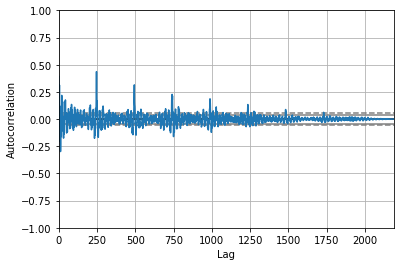

In [11]:
# Автокорреляция 

from pandas.plotting import autocorrelation_plot

'''
Автокорреляционные графики часто используются для проверки случайности во временных рядах. 
Это делается путем вычисления автокорреляций для значений данных с различными временными задержками. 
Если временные ряды случайные, такие автокорреляции должны быть близки к нулю для любого и всех временных разрывов. 
Если временной ряд не является случайным, то одна или несколько автокорреляций будут значительно отличны от нуля. 
Горизонтальные линии, отображаемые на графике, соответствуют доверительным полосам 95% и 99%. 
Пунктирная линия - полоса достоверности 99%.
'''

autocorrelation_plot(data_nal['Nal']) #, figsize=(100, 100))
pyplot.rcParams["figure.figsize"] = (12,6)
pyplot.show()

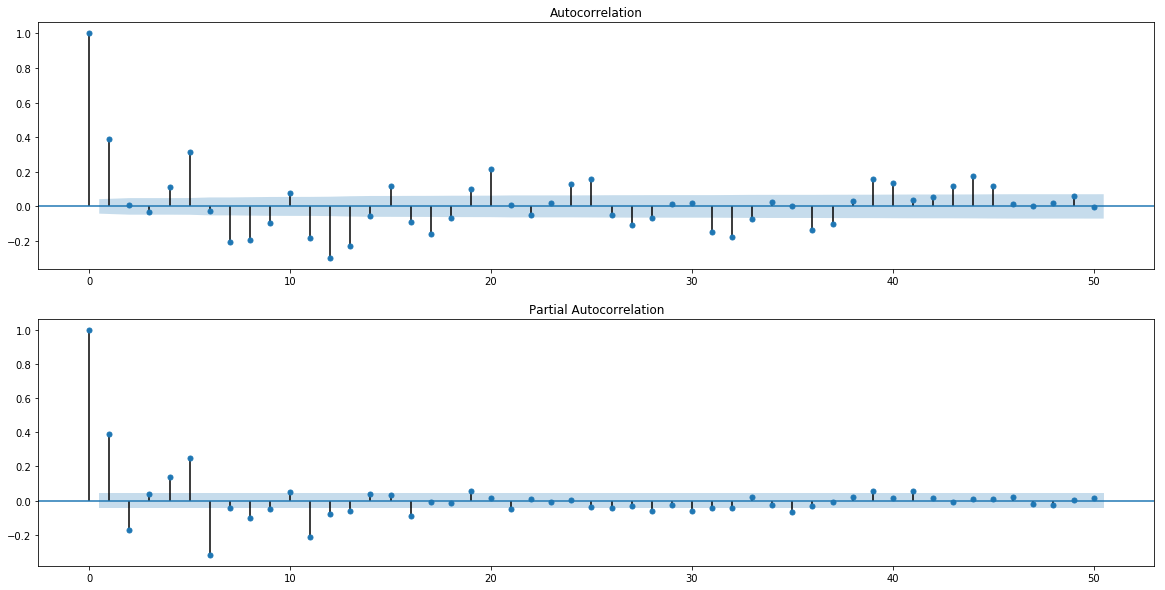

In [12]:
# строим коррелограмму

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(nal, ax=ax[0], lags = 50) # nal.diff().dropna()
fig = sm.graphics.tsa.plot_pacf(nal, ax=ax[1], lags = 50)
plt.show()

In [13]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

In [14]:
#nal['Nal_sez'] = nal['Nal'] - nal['Nal'].shift(24*7)

nal_sez = nal.diff(periods=24*7).dropna()

#tsplot(nal_sez, lags=30)

#nal_sez.plot(figsize=(18,12))

count    2188.000000
mean       -1.439927
std        35.653356
min      -490.590000
25%       -22.225000
50%        -0.510000
75%        17.762500
max       366.220000
Name: Nal, dtype: float64
V = -24.760532


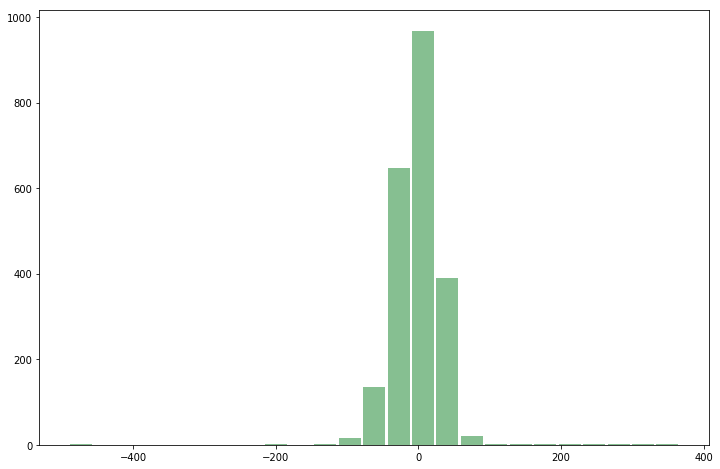

In [15]:
inf = nal.describe()
nal.hist(bins=25, grid=False, color='#86bf91', zorder=2, rwidth=0.9, figsize=(12,8))
#nal.plot(figsize=(12,6))
print(inf)

print('V = %f' % (inf['std']/inf['mean']))

# ряд неоднородный, большой разброс данных
# автокорреляционная функция

In [16]:
# тест Харки-Бера для определения распределения
# если p-value > 0,05 то нулевая гипотеза о нормальном распределении отвергается с этой вероятностью

row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB        p-value        skew            kurtosis    
-------------------------------------------------------------
77357.56342748959     0.0 0.2179355895264229 32.1262604607367
-------------------------------------------------------------


In [17]:
# проверка на нормальность распределения
# нулевая гипотеза - выборка распределена нормально

stat, p = shapiro(tst)
print('W-статистика = %.3f, p = %.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Выборка распределена нормально - нулевая гипотеза не отвергается')
else:
    print('Выборка не распределена нормально - нулевая гипотеза отвергается')

W-статистика = 0.869, p = 0.261
Выборка распределена нормально - нулевая гипотеза не отвергается


In [18]:
def dikifuller(nal):
    #test = sm.tsa.adfuller(nal)
    test = sm.tsa.adfuller(nal)
    print('adf: ', test[0]) 
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [19]:
#ADF-test(differenced-time-series)
dikifuller(nal)

'''
#ADF-test(Original-time-series)
dikifuller(nal['2018-01-01':],'ct')

#ADF-test(differenced-time-series)
dikifuller(nal['2018-01-01':],'c')

#ADF-test(differenced-time-series)
dikifuller(nal, 'c')

#ADF-test(Original-time-series)
dikifuller(nal, 'ct')
'''

adf:  -12.48693133863399
p-value:  3.004215836503141e-23
Critical values:  {'1%': -3.4333712566259007, '5%': -2.8628746849930136, '10%': -2.567480519733324}
единичных корней нет, ряд стационарен


"\n#ADF-test(Original-time-series)\ndikifuller(nal['2018-01-01':],'ct')\n\n#ADF-test(differenced-time-series)\ndikifuller(nal['2018-01-01':],'c')\n\n#ADF-test(differenced-time-series)\ndikifuller(nal, 'c')\n\n#ADF-test(Original-time-series)\ndikifuller(nal, 'ct')\n"

In [20]:
def vyvod(pred, tst):
    
    # коэффициент детерминации - какой процент наблюдений описывает данная модель
    r2 = r2_score(tst, pred)
    print('Коэффициент детерминации: %1.2f' % r2)

    #Среднеквадратичное отклонение нашей модели
    print('Среднеквадратичное отклонение: ',mean_squared_error(tst,pred))

    #Средняя абсолютная ошибка прогноза:
    print('Среднее абсолютное отклонение: ',mean_absolute_error(tst,pred))

    '''
    print('\nСтьюдент: ------------------------------------------')

    t_statistic, p_value = stats.ttest_ind(tst,pred)
    print("T: p_value = {0:5.3f}".format(p_value))

    print('\nФишер: ------------------------------------------')

    #Сравниваемые совокупности должны быть нормально распределены
    #Сравниваемые совокупности должны быть независимыми

    F_statistic, pVal = stats.f_oneway(tst,pred)
    print("F: p_value = {0:5.3f}".format(pVal))

    print('\nFrom the t-test we get t^2={0:5.9f}, and from the F-test F={1:5.9f}'.format(t_statistic**2, F_statistic))

    # численное сравнение
    #np.testing.assert_almost_equal(t_val**2, F_statistic, decimal=7)
    '''

In [21]:
# стандартные методы

In [22]:
# Авторегрессия (AR)

model = AR(trn, missing='drop')
model_fit = model.fit(disp=False)

print('Lag: %s' % model_fit.k_ar)
print('\nCoefficients: %s' % model_fit.params)

#print('Lag: %s' % model_fit.k_ar)
#print('\nCoefficients: %s' % model_fit.params)

# прогноз
pred = model_fit.predict(len(trn), len(trn)+len(tst)-1)
#pred = model_fit.predict(start=datetime(2019,11,18), end=datetime(2019,11,22), dynamic=True)

print('\n')
for i in range(len(pred)):
    print('predicted=%f, expected=%f' % (pred.values[i], tst.values[i]))
print('\n')

pred_df = pd.DataFrame(pred.values, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)))
#pred_df

Lag: 26

Coefficients: const     -1.477814
L1.Nal     0.474348
L2.Nal    -0.161878
L3.Nal     0.033574
L4.Nal    -0.013079
L5.Nal     0.264810
L6.Nal    -0.214593
L7.Nal    -0.004534
L8.Nal    -0.028416
L9.Nal    -0.120542
L10.Nal    0.106720
L11.Nal   -0.146075
L12.Nal   -0.053728
L13.Nal   -0.057431
L14.Nal   -0.016131
L15.Nal    0.060359
L16.Nal   -0.075158
L17.Nal   -0.006757
L18.Nal   -0.034440
L19.Nal    0.032314
L20.Nal    0.038552
L21.Nal   -0.040759
L22.Nal    0.014628
L23.Nal   -0.014224
L24.Nal    0.016752
L25.Nal   -0.016329
L26.Nal   -0.044529
dtype: float64


predicted=-5.042373, expected=16.800000
predicted=5.961882, expected=7.300000
predicted=0.360439, expected=16.200000
predicted=-4.331573, expected=10.700000
predicted=-5.959845, expected=8.400000




C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [23]:
print(model_fit.summary)

<bound method Results.summary of <statsmodels.tsa.ar_model.ARResults object at 0x000001999AE9FEF0>>


Критерий Дики-Фуллера: p=0.000000


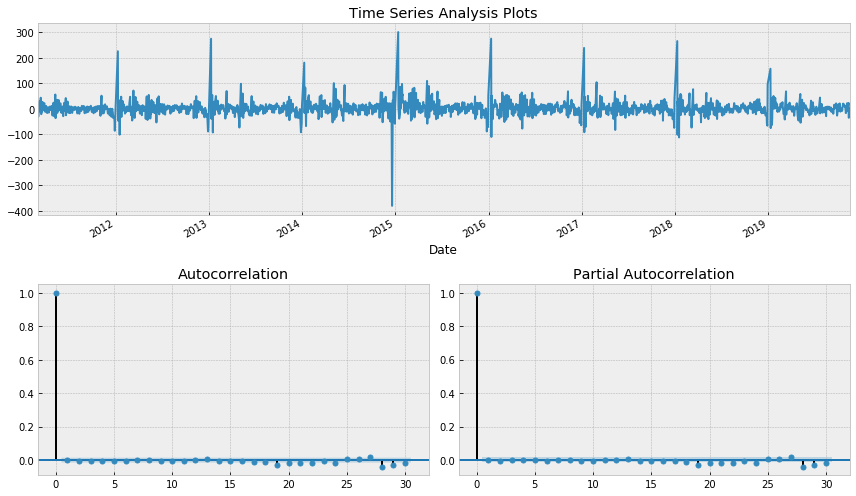

In [24]:
res = model_fit.resid
tsplot(res, lags=30)

In [25]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model_fit.resid,model_fit.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  2.0026280766697457

 Тест среднего значения:
Среднее = -5.270599801651184e-16

 Тест Льюинга-Бокса:
        Q-stat   p-value
0    0.004244  0.948056
1    0.040173  0.980114
2    0.063966  0.995779
3    0.081104  0.999200
4    0.099544  0.999840
5    0.143600  0.999942
6    0.152166  0.999990
7    0.162807  0.999998
8    0.201506  0.999999
9    0.241565  1.000000
10   0.261887  1.000000
11   0.261892  1.000000
12   0.314262  1.000000
13   0.416905  1.000000
14   0.445910  1.000000
15   0.517868  1.000000
16   0.704979  1.000000
17   0.976926  1.000000
18   2.907949  0.999992
19   3.400822  0.999988
20   4.170810  0.999971
21   4.839339  0.999954
22   4.962985  0.999974
23   5.717100  0.999955
24   5.782553  0.999976
25   5.833733  0.999988
26   6.536832  0.999981
27   9.831119  0.999406
28  11.974642  0.997772
29  12.550595  0.997862
30  13.231785  0.997793
31  16.213675  0.990759
32  17.201606  0.989324
33  17.320758  0.992145
34  20.129845  0.97

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [26]:
vyvod(pred.values, tst.values)

#статистика Тейла
df_tail = pd.DataFrame({'tst': tst.values})
df_tail['pred'] = pd.Series(pred.values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -14.02
Среднеквадратичное отклонение:  232.38496604930862
Среднее абсолютное отклонение:  13.682294032802906
Параметр M статистики Тейла:  7.575891570051196


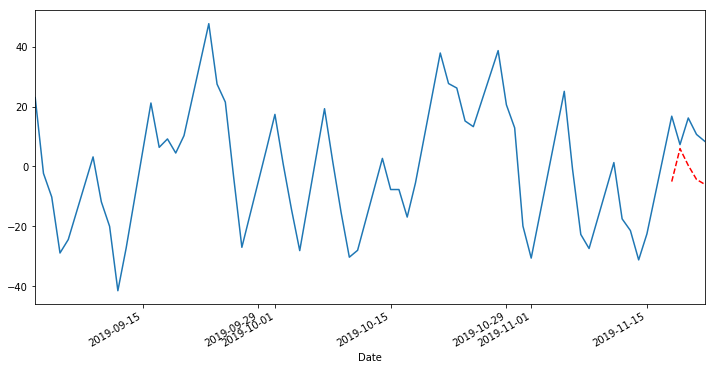

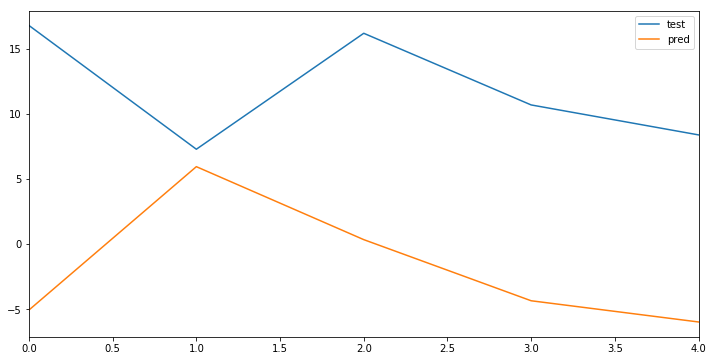

In [27]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred.values}).plot();plt.show()

In [28]:
# AR с учетом историчности

In [29]:
model = AR(trn)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

print('Lag: %s' % model_fit.k_ar)
print('\nCoefficients: %s' % model_fit.params)

# walk forward over time steps in test
history = trn.values[len(trn)-window:]
history = [history[i] for i in range(len(history))]
pred = list()

for t in range(len(tst)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = tst.values[t]
    pred.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(tst, pred)
print('Test MSE: %.3f' % error)

#plot
#pyplot.plot(tst)
#pyplot.plot(predictions, color='red')
#pyplot.show()

pred_df = pd.DataFrame(pred, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)))
pred_df

Lag: 26

Coefficients: const     -1.477814
L1.Nal     0.474348
L2.Nal    -0.161878
L3.Nal     0.033574
L4.Nal    -0.013079
L5.Nal     0.264810
L6.Nal    -0.214593
L7.Nal    -0.004534
L8.Nal    -0.028416
L9.Nal    -0.120542
L10.Nal    0.106720
L11.Nal   -0.146075
L12.Nal   -0.053728
L13.Nal   -0.057431
L14.Nal   -0.016131
L15.Nal    0.060359
L16.Nal   -0.075158
L17.Nal   -0.006757
L18.Nal   -0.034440
L19.Nal    0.032314
L20.Nal    0.038552
L21.Nal   -0.040759
L22.Nal    0.014628
L23.Nal   -0.014224
L24.Nal    0.016752
L25.Nal   -0.016329
L26.Nal   -0.044529
dtype: float64
predicted=-5.042373, expected=16.800000
predicted=16.322764, expected=7.300000
predicted=-2.540617, expected=16.200000
predicted=3.698619, expected=10.700000
predicted=-1.634474, expected=8.400000
Test MSE: 211.884


C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,Pred
2019-11-18,-5.042373
2019-11-19,16.322764
2019-11-20,-2.540617
2019-11-21,3.698619
2019-11-22,-1.634474


Критерий Дики-Фуллера: p=0.000000


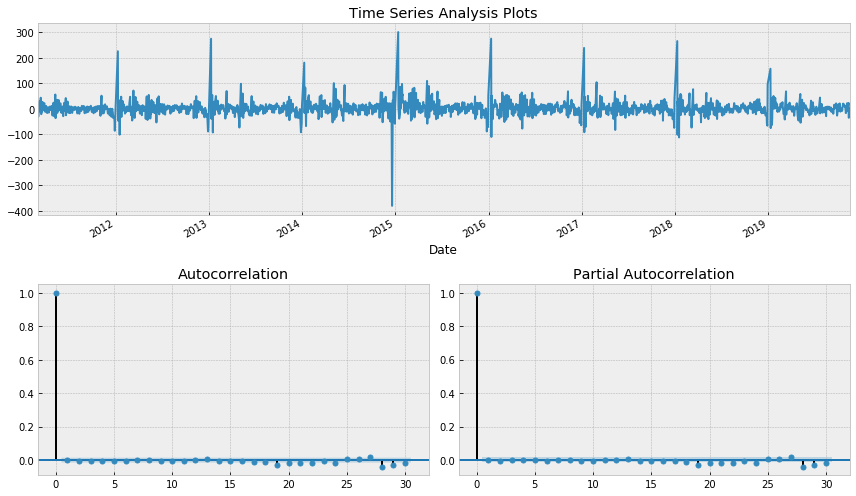

In [30]:
res = model_fit.resid
tsplot(res, lags=30)

In [31]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model_fit.resid,model_fit.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  2.0026280766697457

 Тест среднего значения:
Среднее = -5.270599801651184e-16

 Тест Льюинга-Бокса:
        Q-stat   p-value
0    0.004244  0.948056
1    0.040173  0.980114
2    0.063966  0.995779
3    0.081104  0.999200
4    0.099544  0.999840
5    0.143600  0.999942
6    0.152166  0.999990
7    0.162807  0.999998
8    0.201506  0.999999
9    0.241565  1.000000
10   0.261887  1.000000
11   0.261892  1.000000
12   0.314262  1.000000
13   0.416905  1.000000
14   0.445910  1.000000
15   0.517868  1.000000
16   0.704979  1.000000
17   0.976926  1.000000
18   2.907949  0.999992
19   3.400822  0.999988
20   4.170810  0.999971
21   4.839339  0.999954
22   4.962985  0.999974
23   5.717100  0.999955
24   5.782553  0.999976
25   5.833733  0.999988
26   6.536832  0.999981
27   9.831119  0.999406
28  11.974642  0.997772
29  12.550595  0.997862
30  13.231785  0.997793
31  16.213675  0.990759
32  17.201606  0.989324
33  17.320758  0.992145
34  20.129845  0.97

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [32]:
vyvod(pred, tst.values)

#статистика Тейла
df_tail = pd.DataFrame({'tst': tst.values})
df_tail['pred'] = pd.Series(pred) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -12.70
Среднеквадратичное отклонение:  211.88404917283992
Среднее абсолютное отклонение:  13.32832179350181
Параметр M статистики Тейла:  6.4114784583977436


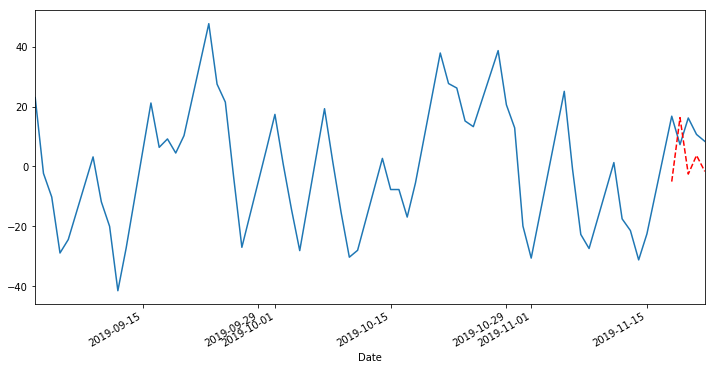

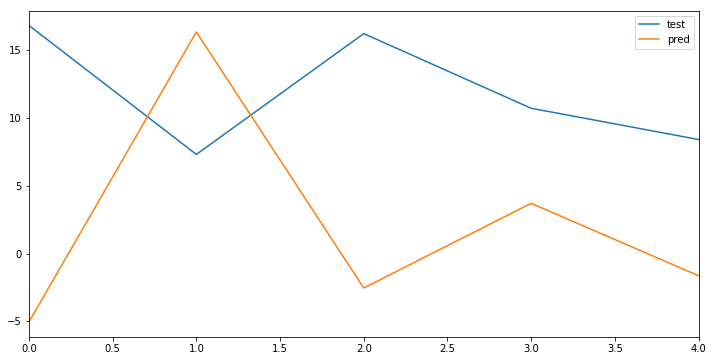

In [33]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred}).plot();plt.show()

In [34]:
# Авторегрессионная скользящая средняя (ARMA)

'''
модель может интерпретироваться как линейная модель множественной регрессии, 
в которой в качестве объясняющих переменных выступают прошлые значения самой зависимой переменной, 
а в качестве регрессионного остатка — скользящие средние из элементов белого шума
'''

model = ARMA(trn, order=(4, 5))
model_fit = model.fit(disp=False)

print(model_fit.summary)

print('Lag: %s' % model_fit.k_ar)
print('\nCoefficients: %s' % model_fit.params)

pred = model_fit.predict(len(trn), len(trn)+len(tst)-1)

print('\n')
for i in range(len(pred)):
    print('predicted=%f, expected=%f' % (pred.values[i], tst.values[i]))
print('\n')

pred_df = pd.DataFrame(pred.values, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)))
pred_df

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARMAResults object at 0x000001999AA4FFD0>>
Lag: 4

Coefficients: const       -1.465482
ar.L1.Nal   -0.973827
ar.L2.Nal   -1.040385
ar.L3.Nal   -0.959492
ar.L4.Nal   -0.862411
ma.L1.Nal    1.444891
ma.L2.Nal    1.502335
ma.L3.Nal    1.369913
ma.L4.Nal    1.120363
ma.L5.Nal    0.389289
dtype: float64


predicted=0.273665, expected=16.800000
predicted=9.919884, expected=7.300000
predicted=1.837366, expected=16.200000
predicted=-11.264677, expected=10.700000
predicted=-7.783023, expected=8.400000




C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Pred
2019-11-18,0.273665
2019-11-19,9.919884
2019-11-20,1.837366
2019-11-21,-11.264677
2019-11-22,-7.783023


Критерий Дики-Фуллера: p=0.000000


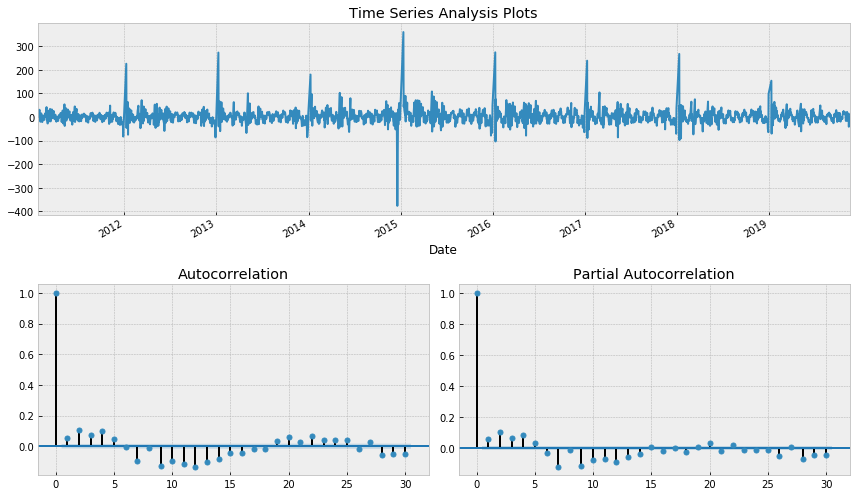

In [35]:
res = model_fit.resid
tsplot(res, lags=30)

In [36]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model_fit.resid,model_fit.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  1.8871839254447533

 Тест среднего значения:
Среднее = 0.0023080628384672397

 Тест Льюинга-Бокса:
         Q-stat       p-value
0     6.907116  8.585338e-03
1    32.151533  1.043238e-07
2    44.523621  1.168151e-09
3    65.501610  2.017392e-13
4    70.920404  6.592403e-14
5    71.025760  2.518488e-13
6    92.640362  3.546556e-17
7    92.977303  1.154619e-16
8   127.913590  3.183579e-23
9   149.317210  5.150684e-27
10  178.805754  1.808062e-32
11  217.664734  7.236699e-40
12  241.590498  3.559644e-44
13  256.966925  1.039181e-46
14  261.411087  5.508774e-47
15  265.624251  3.191439e-47
16  266.425647  9.083868e-47
17  267.144245  2.613222e-46
18  269.512742  3.378128e-46
19  277.338195  3.339987e-47
20  279.074792  5.627111e-47
21  288.026789  3.243844e-48
22  291.483833  2.395679e-48
23  295.453188  1.378477e-48
24  298.575551  1.160787e-48
25  299.249710  2.981914e-48
26  300.937641  4.726657e-48
27  307.673404  7.330478e-49
28  312.772052  2.3

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [37]:
vyvod(pred.values, tst.values)

#статистика Тейла
df_tail = pd.DataFrame({'tst': tst.values})
df_tail['pred'] = pd.Series(pred.values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -14.91
Среднеквадратичное отклонение:  246.12121302286727
Среднее абсолютное отклонение:  14.331310579788004
Параметр M статистики Тейла:  9.807990847701454


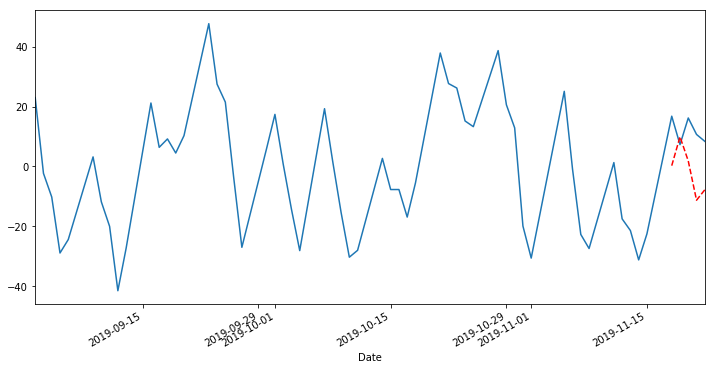

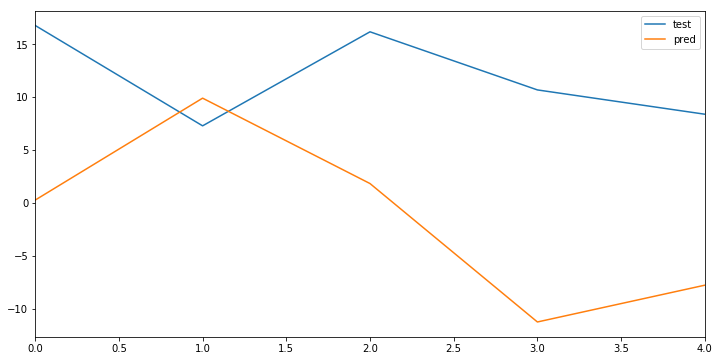

In [38]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred.values}).plot();plt.show()

In [39]:
# Авторегрессионное интегрированное скользящее среднее (ARIMA)

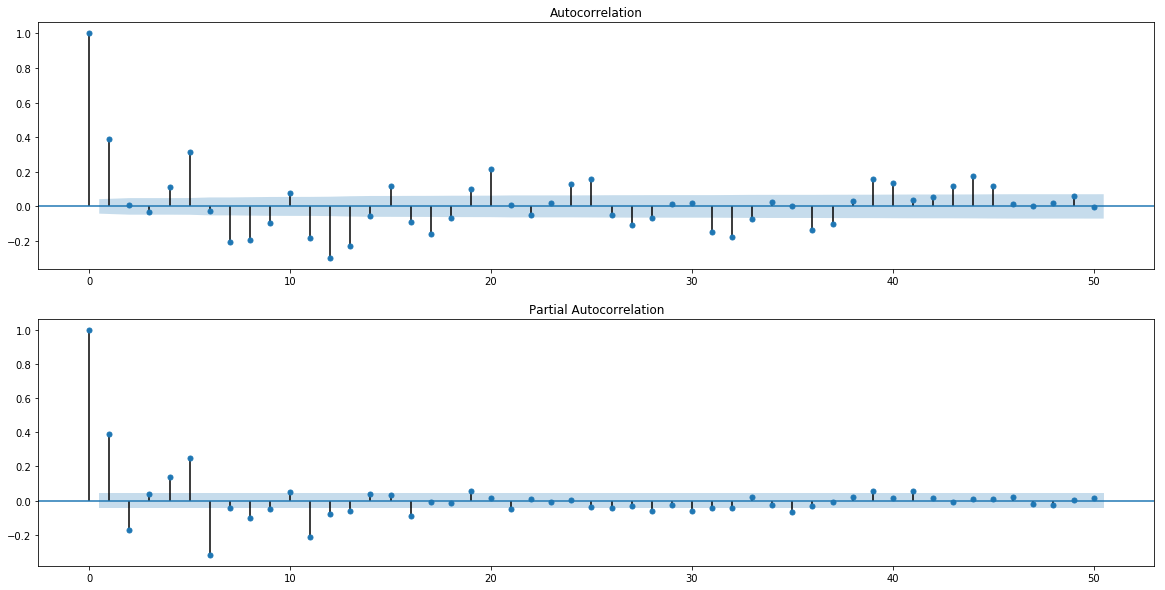

'\np = 4\nd = 1\nq = 4\n'

In [40]:
'''
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA


Параметр d есть и он равен 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

'''

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(nal, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(nal, lags=50, ax=ax[1])
plt.show()

'''
p = 4
d = 1
q = 4
'''

In [41]:
# используем метод arma_order_select_ic для автоматического нахождения параметров модели arima

resDiff = sm.tsa.arma_order_select_ic(nal, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


In [12]:
data_model = trn

model = sm.tsa.ARIMA(data_model, order=(7,1,4)).fit(full_output=True , disp=0) #(14,1,6)
print(model.summary2())
#print(model.resid)

pred = model.predict(len(nal)-5, len(nal)-1)

pred_df = pd.DataFrame(pred.values, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22), freq='B'))
#pred_df

                           Results: ARIMA
Model:              ARIMA            BIC:                 20943.6404
Dependent Variable: D.Nal            Log-Likelihood:      -10422.   
Date:               2020-01-08 02:09 Scale:               1.0000    
No. Observations:   2182             Method:              css-mle   
Df Model:           12               Sample:              1         
Df Residuals:       2170                                  3         
Converged:          1.0000           S.D. of innovations: 28.651    
No. Iterations:     103.0000         HQIC:                20896.728 
AIC:                20869.6964                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            0.0005    0.0008    0.5921  0.5539  -0.0011   0.0020
ar.L1.D.Nal     -0.0068    0.0308   -0.2197  0.8261  -0.0

Критерий Дики-Фуллера: p=0.000000


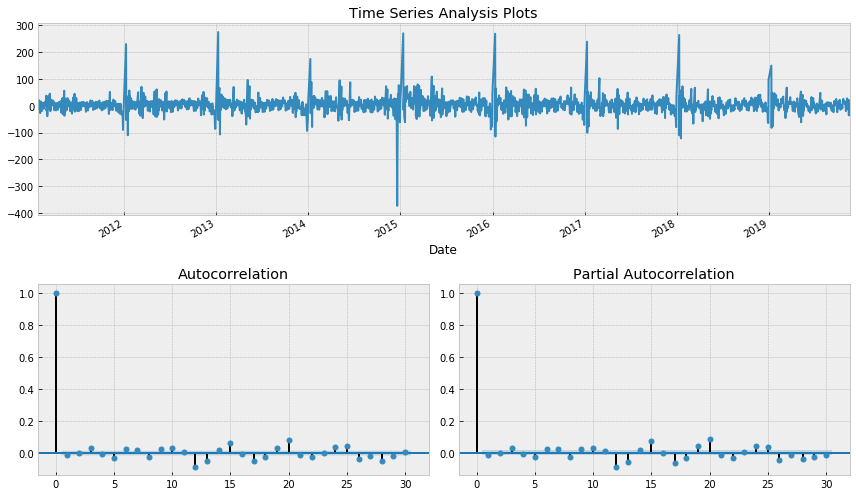

In [15]:
res = model.resid
tsplot(res, lags=30)

In [16]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test
'''
print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)



 Тест Дарбина-Уотсона:
durbin_watson:  2.025603845359927

 Тест среднего значения:
Среднее = 0.19964521689756243

 Тест Голдфилда-Квандта:

   F statistic         p-value      
------------------------------------
0.790351562733262 0.9999474499459111
------------------------------------

 Тест Льюинга-Бокса:
         Q-stat       p-value
0     0.363311  5.466733e-01
1     0.364748  8.332898e-01
2     2.560761  4.644103e-01
3     2.628349  6.218096e-01
4     4.319103  5.044452e-01
5     5.423410  4.907616e-01
6     6.325338  5.023158e-01
7     8.013713  4.321318e-01
8     9.496481  3.927615e-01
9    11.570458  3.148318e-01
10   11.703423  3.863438e-01
11   27.435443  6.685129e-03
12   33.089129  1.652277e-03
13   33.890964  2.139445e-03
14   42.099904  2.169330e-04
15   42.122574  3.783259e-04
16   48.046947  8.446286e-05
17   49.678706  8.440383e-05
18   52.197904  6.179610e-05
19   66.237683  7.400625e-07
20   66.541587  1.245740e-06
21   67.990824  1.364477e-06
22   67.994561  2.471

In [20]:
vyvod(pred.values, tst.values)

#статистика Тейла
df_tail = pd.DataFrame({'tst':tst.values})
df_tail['pred'] = pd.Series(pred.values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -6.33
Среднеквадратичное отклонение:  113.37936022543947
Среднее абсолютное отклонение:  7.929235391010716
Параметр M статистики Тейла:  3.185296312477675


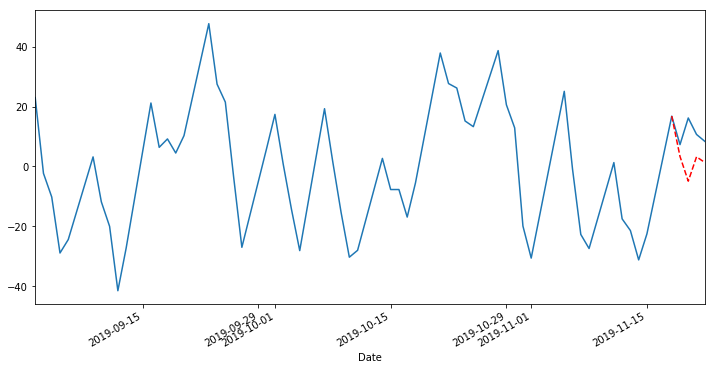

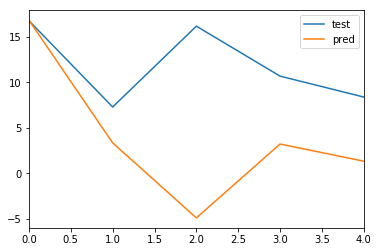

In [21]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred.values}).plot();plt.show()

Fit ARIMA: order=(4, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=21224.930, BIC=21281.810, Fit time=3.231 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=22223.770, BIC=22235.146, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=22148.953, BIC=22166.017, Fit time=0.090 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=21844.735, BIC=21861.799, Fit time=0.291 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=22221.771, BIC=22227.459, Fit time=0.033 seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=21142.990, BIC=21194.182, Fit time=3.903 seconds
Near non-invertible roots for order (3, 1, 4)(0, 0, 0, 1); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=21235.946, BIC=21287.138, Fit time=1.843 seconds
Fit ARIMA: order=(5, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=21018.699, BIC=2108

In [51]:
# Auto Arima

!pip install pmdarima
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(trn, start_p=4, start_q=4,max_p=9, max_q=9, start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True) #m=12
#print(stepwise_model.aic())

#stepwise_model = auto_arima(trn, trace=True, error_action='ignore', suppress_warnings=True)

######################################################################################################

model = stepwise_model.fit(trn)

print(model.summary())
#print(model.resid)

#pred = model.predict(len(nal)-5, len(nal)-1)
pred = model.predict(n_periods=5)

pred_df = pd.DataFrame(pred, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22), freq='B'))
pred_df

#####################################################################################################

res = model.resid()
tsplot(res, lags=30)

#####################################################################################################

# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)

#######################################################################################################

vyvod(pred, tst.values)

#статистика Тейла
df_tail = pd.DataFrame({'tst':tst.values})
df_tail['pred'] = pd.Series(pred) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2183
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -10429.529
Date:                Wed, 08 Jan 2020   AIC                          20883.058
Time:                        01:22:19   BIC                          20951.314
Sample:                             0   HQIC                         20908.010
                               - 2183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.005      0.144      0.886      -0.009       0.011
ar.L1         -0.4641      0.030    -15.670      0.000      -0.522      -0.406
ar.L2         -0.4110      0.031    -13.291      0.0

,Pred
2019-11-18,-2.613023
2019-11-19,6.877945
2019-11-20,-3.634545
2019-11-21,-8.442347
2019-11-22,-9.881370


Критерий Дики-Фуллера: p=0.000000


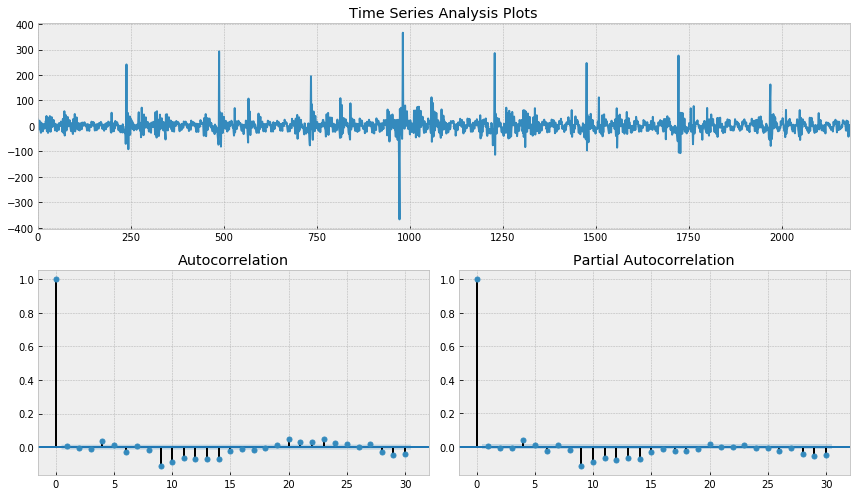


 Тест Дарбина-Уотсона:
durbin_watson:  1.991424982797327

 Тест среднего значения:
Среднее = 0.05612803108428084

 Тест Льюинга-Бокса:
         Q-stat       p-value
0     0.036774  8.479254e-01
1     0.177465  9.150905e-01
2     0.365734  9.472264e-01
3     3.642854  4.564919e-01
4     3.943093  5.576380e-01
5     5.488439  4.828551e-01
6     5.628048  5.837871e-01
7     6.322605  6.111442e-01
8    34.020603  8.858252e-05
9    52.295024  1.006212e-07
10   61.343983  5.213022e-09
11   72.853483  9.333834e-11
12   83.390213  2.529383e-12
13   94.049426  6.484335e-14
14   95.319482  9.990617e-14
15   95.559227  2.338387e-13
16   96.392955  4.126264e-13
17   96.430796  9.932325e-13
18   96.952655  1.900807e-12
19  102.072730  5.351893e-13
20  104.261745  5.048247e-13
21  106.595171  4.451624e-13
22  111.472889  1.384985e-13
23  112.747045  1.862241e-13
24  113.529179  3.013914e-13
25  113.533848  6.545228e-13
26  114.226340  1.063730e-12
27  116.080159  1.084418e-12
28  121.029318  3.2929

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Коэффициент детерминации: -18.02
Среднеквадратичное отклонение:  294.21813471719935
Среднее абсолютное отклонение:  15.418667891032873
Параметр M статистики Тейла:  10.77470426627439


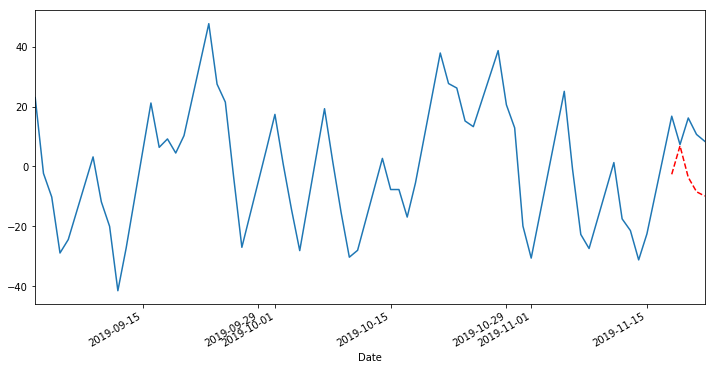

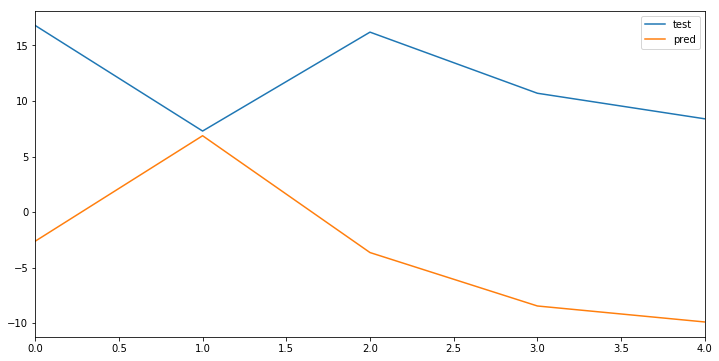

In [55]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred}).plot();plt.show()

In [53]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    trn = X[:'2019-11-15']
    tst = X['2019-11-18':'2019-11-22']
    
    data_model = trn
    model = sm.tsa.ARIMA(data_model, order=arima_order).fit(full_output=True , disp=0)
    #model = sm.tsa.SARIMAX(data_model, order=arima_order, seasonal_order=(0, 0, 0, 0)).fit(full_output=True , disp=0)
    pred = model.predict(len(nal)-5, len(nal)-1)
    
    '''
    history = [x for x in trn]
    # make predictions
    predictions = list()
    for t in range(len(tst)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(tst[t])
    # calculate out of sample error
    '''
    
    error = mean_squared_error(tst, pred)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = [4,5,6,7,8,9]
d_values = [0,1]
q_values = [4,5,6,7,8,9]
warnings.filterwarnings("ignore")
evaluate_models(nal, p_values, d_values, q_values)

ARIMA(4, 0, 4) MSE=311.931
ARIMA(4, 0, 5) MSE=246.120
ARIMA(4, 0, 6) MSE=266.886
ARIMA(4, 0, 7) MSE=213.409
ARIMA(4, 0, 8) MSE=208.333
ARIMA(4, 0, 9) MSE=242.488
ARIMA(4, 1, 4) MSE=165.527
ARIMA(4, 1, 5) MSE=227.888
ARIMA(4, 1, 6) MSE=295.513
ARIMA(4, 1, 7) MSE=299.596
ARIMA(4, 1, 8) MSE=294.312
ARIMA(4, 1, 9) MSE=275.178
ARIMA(5, 0, 4) MSE=303.114
ARIMA(5, 0, 5) MSE=297.420
ARIMA(5, 0, 6) MSE=333.117
ARIMA(5, 0, 7) MSE=327.625
ARIMA(5, 0, 8) MSE=321.569
ARIMA(5, 0, 9) MSE=354.561
ARIMA(5, 1, 4) MSE=113.711
ARIMA(6, 0, 4) MSE=265.662
ARIMA(6, 0, 5) MSE=250.394
ARIMA(6, 0, 6) MSE=273.785
ARIMA(6, 0, 7) MSE=143.293
ARIMA(6, 0, 8) MSE=115.681
ARIMA(6, 0, 9) MSE=134.418
ARIMA(6, 1, 4) MSE=136.691
ARIMA(7, 0, 4) MSE=307.125
ARIMA(7, 0, 5) MSE=267.092
ARIMA(7, 0, 6) MSE=261.667
ARIMA(7, 0, 7) MSE=119.627
ARIMA(7, 0, 8) MSE=126.583
ARIMA(7, 0, 9) MSE=142.203
ARIMA(7, 1, 4) MSE=113.208
ARIMA(8, 0, 4) MSE=299.853
ARIMA(8, 0, 5) MSE=289.080
ARIMA(8, 0, 6) MSE=268.692
ARIMA(8, 0, 7) MSE=132.964
A

In [59]:
# Сезонные авторегрессионные интегрированные скользящие средние (SARIMA)

In [112]:
data_model = trn
model = sm.tsa.SARIMAX(data_model, order=(7,0,7), seasonal_order=(3, 0, 4, 1)).fit(full_output=True , disp=0)
print(model.summary())

pred = model.predict(len(nal)-5, len(nal)-1)

pred_df = pd.DataFrame(pred.values, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)))
#pred_df

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               Nal   No. Observations:                 2183
Model:             SARIMAX(7, 0, 7)x(3, 0, 4, 1)   Log Likelihood              -10378.778
Date:                           Wed, 08 Jan 2020   AIC                          20801.556
Time:                                   01:54:45   BIC                          20926.702
Sample:                                        0   HQIC                         20847.303
                                          - 2183                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6224     19.921      0.031      0.975     -38.423      39.668
ar.L2          0.1594     17.048      0.009

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Критерий Дики-Фуллера: p=0.000000


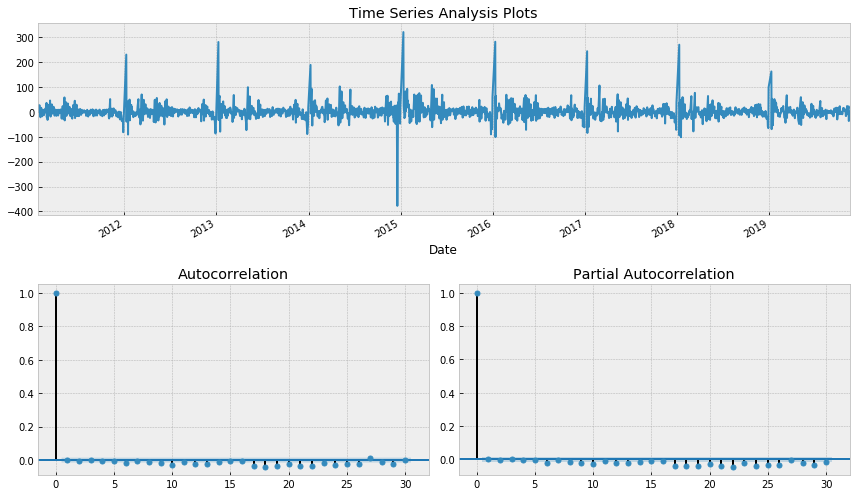

In [113]:
res = model.resid
tsplot(res, lags=30)

In [114]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  1.9978260655984281

 Тест среднего значения:
Среднее = -0.9654034966887607

 Тест Льюинга-Бокса:
        Q-stat   p-value
0    0.000197  0.988789
1    0.015917  0.992073
2    0.028094  0.998758
3    0.075094  0.999313
4    0.092046  0.999868
5    0.946529  0.987558
6    1.046663  0.994040
7    1.497757  0.992745
8    2.377802  0.983991
9    4.091376  0.943131
10   4.281740  0.960939
11   5.269682  0.948359
12   6.342599  0.932791
13   6.667092  0.946785
14   6.754918  0.964097
15   6.865424  0.975769
16  10.060236  0.901065
17  13.425333  0.765711
18  16.144250  0.647633
19  17.230024  0.637991
20  19.956989  0.523987
21  23.159589  0.392765
22  23.845458  0.412407
23  25.958021  0.355298
24  27.205408  0.345701
25  28.358409  0.341051
26  28.609520  0.380084
27  28.935967  0.415781
28  30.132272  0.407422
29  30.134329  0.458789
30  30.719585  0.480405
31  30.844727  0.524909
32  37.657556  0.264473
33  38.325205  0.279637
34  39.193222  0.28723

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [115]:
vyvod(pred.values, tst.values)
#статистика Тейла
df_tail = pd.DataFrame({'tst':tst.values})
df_tail['pred'] = pd.Series(pred.values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -7.63
Среднеквадратичное отклонение:  133.44033231013077
Среднее абсолютное отклонение:  10.773792831127277
Параметр M статистики Тейла:  4.258274251484071


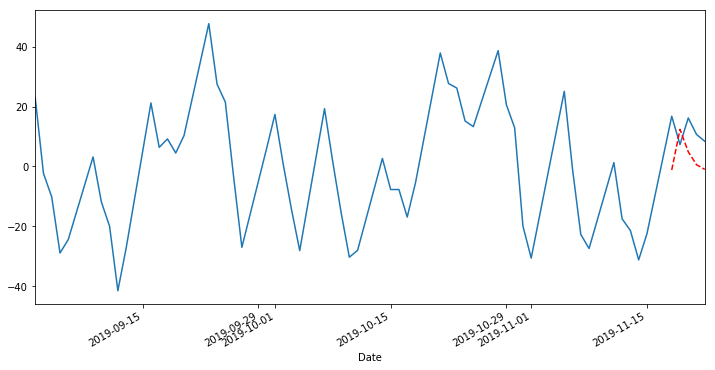

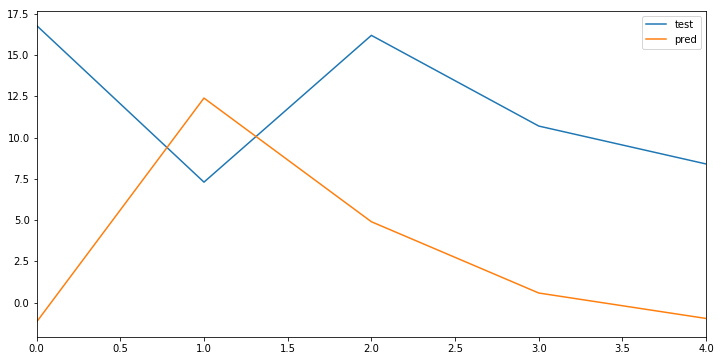

In [116]:
data['Nal']['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred.values}).plot();plt.show()

In [55]:
# Сезонные авторегрессионные интегрированные скользящие средние с экзогенными регрессорами (SARIMAX)

In [48]:
data_model = trn
model = sm.tsa.SARIMAX(data_model, order=(6,0,8), seasonal_order=(0, 0, 0, 0), trend='c').fit(full_output=True , disp=0)

print(model.summary())

#pred = model.predict('2018-12-31','2019-11-30', typ='levels')
pred = model.predict(len(nal)-5, len(nal)-1)

pred_df = pd.DataFrame(pred.values, columns=['Pred'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)) )
#pred_df

                           Statespace Model Results                           
Dep. Variable:                    Nal   No. Observations:                 2183
Model:               SARIMAX(6, 0, 8)   Log Likelihood              -10381.352
Date:                Wed, 08 Jan 2020   AIC                          20794.703
Time:                        02:22:42   BIC                          20885.719
Sample:                             0   HQIC                         20827.974
                               - 2183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7031      0.515     -1.366      0.172      -1.712       0.306
ar.L1          0.8773      0.024     36.161      0.000       0.830       0.925
ar.L2         -0.0565      0.036     -1.556      0.1

Критерий Дики-Фуллера: p=0.000000


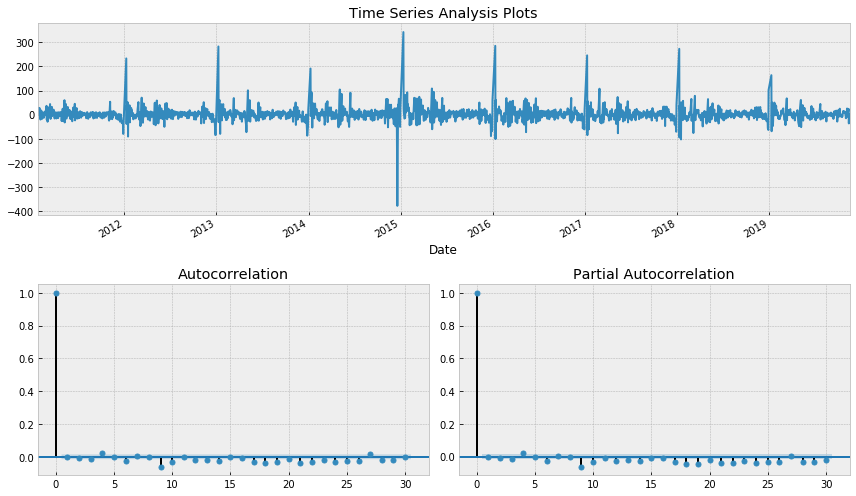

In [49]:
res = model.resid
tsplot(res, lags=30)

In [50]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  2.0068985072997028

 Тест среднего значения:
Среднее = 0.1306267391937102

 Тест Льюинга-Бокса:
        Q-stat   p-value
0    0.029667  0.863248
1    0.265710  0.875592
2    0.705937  0.871807
3    1.608259  0.807307
4    1.609951  0.900043
5    2.844622  0.828081
6    2.855470  0.898043
7    2.860416  0.942809
8   10.735569  0.294271
9   13.178572  0.213858
10  13.212231  0.279681
11  14.308915  0.281418
12  15.354914  0.285723
13  17.168789  0.247295
14  17.174072  0.308565
15  17.222371  0.371351
16  19.293492  0.311948
17  22.408564  0.214350
18  25.074820  0.158094
19  25.499054  0.183001
20  28.235792  0.133590
21  30.143978  0.115007
22  30.797082  0.127860
23  32.929841  0.105562
24  34.085050  0.106102
25  35.389942  0.103472
26  36.071780  0.113739
27  36.689770  0.125861
28  37.591005  0.131703
29  37.609546  0.160034
30  38.092129  0.177943
31  38.172342  0.209240
32  44.006175  0.095414
33  45.357378  0.092224
34  46.076308  0.099694

In [51]:
vyvod(pred.values, tst.values)
#статистика Тейла
df_tail = pd.DataFrame({'tst':tst.values})
df_tail['pred'] = pd.Series(pred.values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -7.45
Среднеквадратичное отклонение:  130.7582438772645
Среднее абсолютное отклонение:  10.789378353499947
Параметр M статистики Тейла:  4.278088552109888


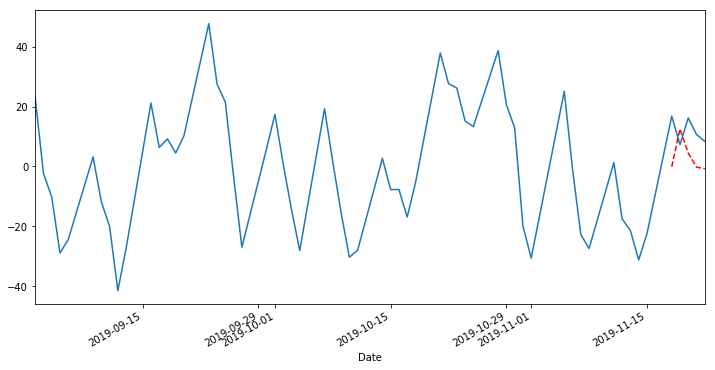

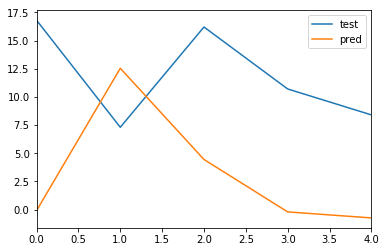

In [52]:
nal['09.01.2019':].plot(figsize=(12,6))
pred_df['Pred'].plot(style='r--')

pd.DataFrame({'test':tst.values,'pred':pred.values}).plot();plt.show()

In [61]:
# Векторная авторегрессия (VAR)

from statsmodels.tsa.vector_ar.var_model import VAR

trn_start,trn_end = '2011-01-11','2019-11-15'
tst_start,tst_end = '2019-11-18','2019-11-22'
trn_df = data[:'2019-11-15']
tst_df = data['2019-11-18':'2019-11-22']

In [62]:
data_model = trn_df

model = VAR(data_model)
model_fit = model.fit(method = 'ols', ic='bic') #‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None

print(model_fit.summary())

pred = model_fit.forecast(model_fit.y, steps=5)
pred_df = pd.DataFrame(pred, columns=['Nal','Ost','Rez'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22) ))
#pred_df

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jan, 2020
Time:                     23:10:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    19.9463
Nobs:                     2177.00    HQIC:                   19.8518
Log likelihood:          -30759.6    FPE:                3.96191e+08
AIC:                      19.7974    Det(Omega_mle):     3.85996e+08
--------------------------------------------------------------------
Results for equation Nal
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.902102         0.634398           -1.422           0.155
L1.Nal         0.502590         0.021412           23.473           0.000
L1.Ost        -0.002113         0.004179           -0.506           0.613
L1.Rez        -0

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Критерий Дики-Фуллера: p=0.000000


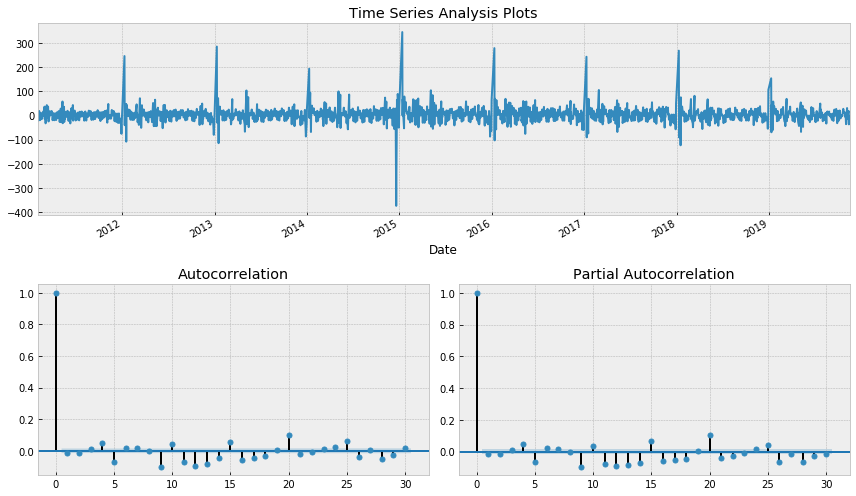

In [63]:
res = model_fit.resid['Nal']
tsplot(res, lags=30)

In [64]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  2.0320763447346475

 Тест среднего значения:
Среднее = -7.154385286109967e-15

 Тест Льюинга-Бокса:
         Q-stat       p-value
0     0.561490  4.536606e-01
1     1.118270  5.717034e-01
2     1.275769  7.348948e-01
3     6.022643  1.974636e-01
4    16.365512  5.874424e-03
5    17.278093  8.313757e-03
6    18.153727  1.129534e-02
7    18.186526  1.987073e-02
8    40.169500  7.079590e-06
9    43.980818  3.317882e-06
10   55.872465  5.362815e-08
11   74.913920  3.814432e-11
12   91.049972  8.798571e-14
13   96.166534  2.563438e-14
14  102.537751  4.301947e-15
15  109.710561  5.090671e-16
16  114.773145  1.516307e-16
17  116.948322  1.576803e-16
18  117.033831  3.966989e-16
19  139.248715  7.025920e-20
20  140.415710  1.141580e-19
21  140.568164  2.820474e-19
22  140.948536  6.180957e-19
23  142.038388  9.829782e-19
24  149.993739  8.455570e-20
25  152.962424  6.023726e-20
26  153.000135  1.463142e-19
27  158.645023  3.349978e-20
28  159.975519  4.

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [65]:
vyvod(pred_df['Nal'].values, tst_df['Nal'].values)

#статистика Тейла
df_tail = pd.DataFrame({'tst': tst_df['Nal'].values})
df_tail['pred'] = pd.Series(pred_df['Nal'].values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -15.59
Среднеквадратичное отклонение:  256.5782905808054
Среднее абсолютное отклонение:  15.352404279982313
Параметр M статистики Тейла:  9.132495849705712


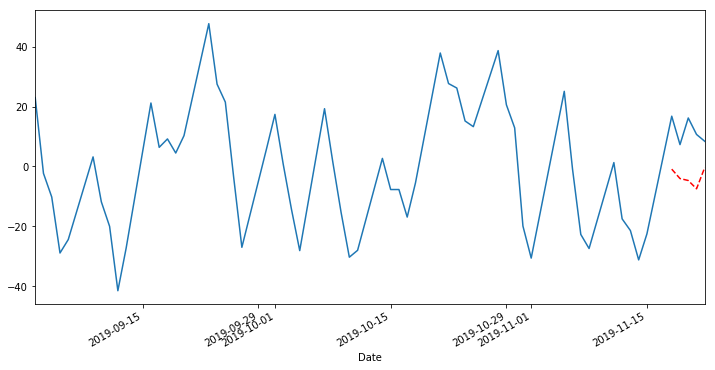

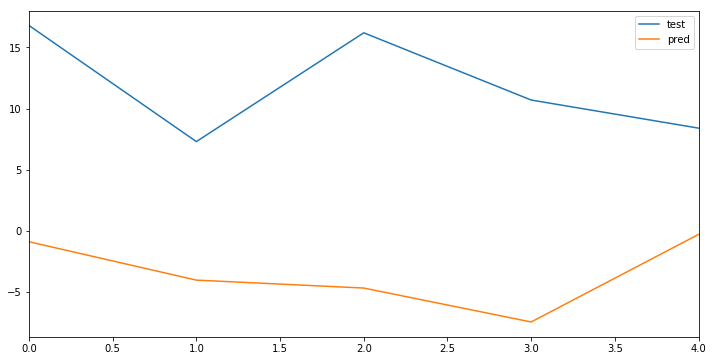

In [66]:
data['Nal']['09.01.2019':].plot(figsize=(12,6))
pred_df['Nal'].plot(style='r--')

pd.DataFrame({'test':tst_df['Nal'].values,'pred':pred_df['Nal'].values}).plot();plt.show()

In [67]:
# VECM

model = VECM(endog = trn_df, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
#model = VECM(endog = trn_df, k_ar_diff = 1, coint_rank = 2, deterministic = 'co')

model_fit = model.fit()
pred = model_fit.predict(steps=5)

print(model_fit.summary())
model_fit.gamma.round(4)

pred_df = pd.DataFrame(pred, columns=['Nal','Ost','Rez'], index=pd.date_range(start=datetime(2019,11,18), end=datetime(2019,11,22)))
#pred_df

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Det. terms outside the coint. relation & lagged endog. parameters for equation Nal
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Nal         0.1622      0.044      3.680      0.000       0.076       0.249
L1.Ost         0.0142      0.015      0.960      0.337      -0.015       0.043
L1.Rez         0.7677      0.391      1.962      0.050       0.001       1.535
L2.Nal        -0.0056      0.041     -0.135      0.893      -0.087       0.075
L2.Ost         0.0042      0.014      0.309      0.758      -0.023       0.031
L2.Rez         0.6167      0.369      1.671      0.095      -0.107       1.340
L3.Nal         0.0281      0.039      0.720      0.471      -0.048       0.104
L3.Ost         0.0046      0.012      0.367      0.714      -0.020       0.029
L3.Rez         0.6138      0.345      1.777      0.076      -0.063       1.291
L4.Nal         0.0409      0.036      1.123     

In [68]:
d = model_fit.resid
df_resid = pd.DataFrame(data=d, columns = ['Nal','Ost','Rez'])
#df_resid

Критерий Дики-Фуллера: p=0.000000


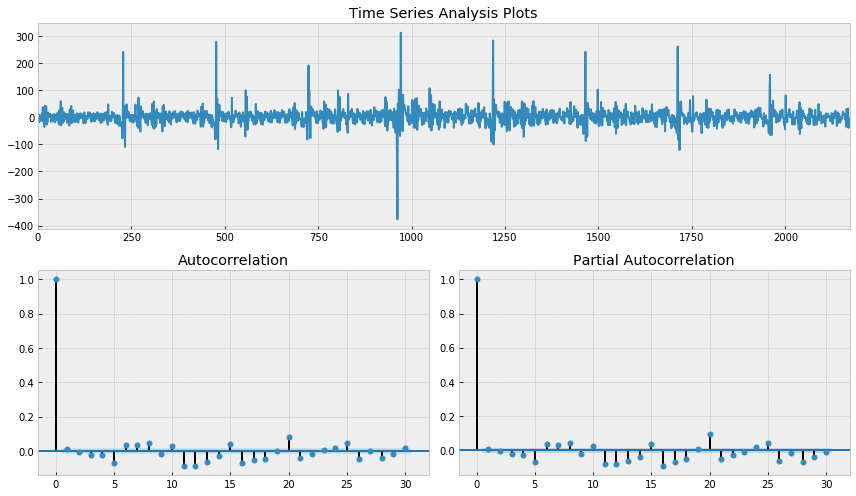

In [69]:
res = df_resid['Nal']
tsplot(res, lags=30)

In [70]:
# Тест Дарбина-Уотсона
print('\n Тест Дарбина-Уотсона:')
print('durbin_watson: ',durbin_watson(res))

print('\n Тест среднего значения:')
# тест - среднее равно 0
print('Среднее =', np.average(res))

# тест Голдфилда-Квандта на гомоскедастичность

'''
# тест Уайта на гомоскедастичность
row = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(model.resid,model.model.exog)
a = np.vstack([white_test])
itog = SimpleTable(a, row)
print('\n',itog)


breuschpagan_test = het_breuschpagan(model.resid,model.model.exog)
breuschpagan_test

print('\n Тест Голдфилда-Квандта:')
row = ['F statistic', 'p-value']
goldfeldquandt_test = het_goldfeldquandt(model.resid,model.model.exog)
a = np.vstack([goldfeldquandt_test])
itog = SimpleTable(a, row)
print('\n',itog)
'''

# тест на отсутствие автокорреляции
q_test = sm.tsa.stattools.acf(res, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

df1 = pd.DataFrame(data=q_test[1], columns=['Q-stat'])
df2 = pd.DataFrame(data=q_test[2], columns=['p-value'])
result = pd.concat([df1, df2], axis=1, sort=False)
print('\n Тест Льюинга-Бокса:\n',result)

print('\n Тест Харки-Бера:')
# тест на нормальное распределение
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(nal)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print('\n',itog)


 Тест Дарбина-Уотсона:
durbin_watson:  1.9811380015113778

 Тест среднего значения:
Среднее = -1.948842478200735e-15

 Тест Льюинга-Бокса:
         Q-stat       p-value
0     0.193006  6.604266e-01
1     0.298180  8.614914e-01
2     1.328094  7.224730e-01
3     2.735239  6.030625e-01
4    13.334694  2.043628e-02
5    15.806939  1.482858e-02
6    18.138867  1.135893e-02
7    23.047752  3.303477e-03
8    23.895137  4.470212e-03
9    25.492709  4.485834e-03
10   41.896716  1.687757e-05
11   58.649731  3.973880e-08
12   68.492190  1.519192e-09
13   70.607605  1.497761e-09
14   74.618951  6.633910e-10
15   84.921875  2.132656e-11
16   91.597199  3.123907e-12
17   96.476577  9.743613e-13
18   96.476637  2.315076e-12
19  111.143220  1.214754e-14
20  114.436139  7.410765e-15
21  114.969464  1.417840e-14
22  115.010087  3.257350e-14
23  115.742672  5.523738e-14
24  120.559012  1.764440e-14
25  125.802283  4.741994e-15
26  125.807220  1.061206e-14
27  129.757452  4.804969e-15
28  130.616549  7.

C:\Programs\Anaconda\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [71]:
vyvod(pred_df['Nal'].values, tst_df['Nal'].values)

#статистика Тейла
df_tail = pd.DataFrame({'tst': tst_df['Nal'].values})
df_tail['pred'] = pd.Series(pred_df['Nal'].values) 
df_tail['M_pred'] = df_tail.apply(lambda x: (abs(x['tst']-x['pred'])/x['tst'])**2, axis =  1)
M = sum(df_tail['M_pred'])
print('Параметр M статистики Тейла: ',M)

Коэффициент детерминации: -14.46
Среднеквадратичное отклонение:  239.18860273152146
Среднее абсолютное отклонение:  14.565888470462607
Параметр M статистики Тейла:  8.257180615943184


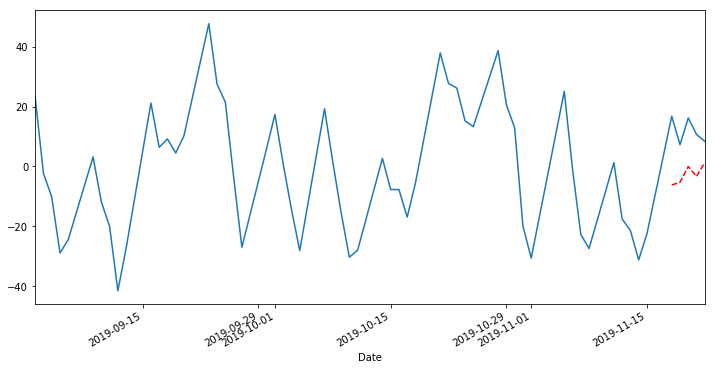

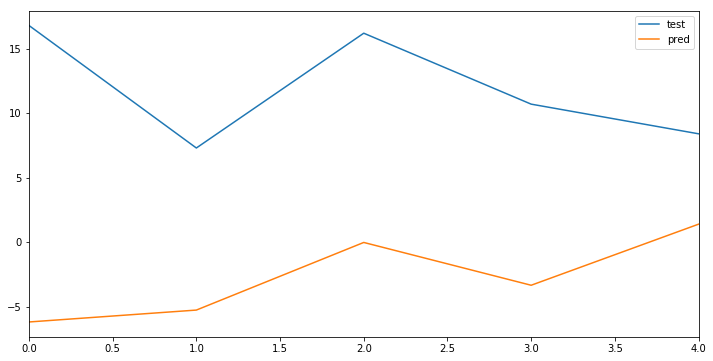

In [72]:
data['Nal']['09.01.2019':].plot(figsize=(12,6))
pred_df['Nal'].plot(style='r--')

pd.DataFrame({'test':tst_df['Nal'].values,'pred':pred_df['Nal'].values}).plot();plt.show()

In [73]:
# TensorFlow

In [74]:
data = pd.read_excel(r'C:\Users\Nikolay\Google Диск\9 семестр\НИР\dataset.xlsx', 'LIKV2', names=['Date', 'Nal','Ost','Rez'])
#data = pd.read_excel(r'C:\Users\Nikolay\Google Диск\9 семестр\НИР\dataset.xlsx', 'LIKV2', parse_dates=True, dayfirst=True, index_col= 0, names=['Date', 'Nal','Ost','Rez'])

data.head()

,Date,Nal,Ost,Rez
0,2011-01-25,25.58,-182.75,2.04
1,2011-01-26,15.06,-64.81,-5.68
2,2011-01-27,2.88,4.57,0.00
3,2011-01-28,-1.00,4.62,0.02
4,2011-01-31,29.18,10.67,0.00


In [75]:
# Удаляем лишние

data_n = data.copy(deep=True)
data_n = data_n.drop(['Date'], axis=1)

# Размерность датасета
n = data_n.shape[0]
p = data_n.shape[1]

data_n = data_n.values
data_n

array([[  25.58, -182.75,    2.04],
       [  15.06,  -64.81,   -5.68],
       [   2.88,    4.57,    0.  ],
       ...,
       [  16.2 ,  -85.7 ,    0.  ],
       [  10.7 ,   85.3 ,    0.  ],
       [   8.4 ,  -57.6 ,    0.  ]])

In [76]:
train_start = 0
train_end = 2182
test_start = 2183
test_end = n

data_train = data_n[np.arange(train_start, train_end), :]
data_test = data_n[np.arange(test_start, test_end), :]

In [77]:
# Масштабирование данных
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [78]:
# https://habr.com/ru/company/iticapital/blog/354732/
# https://github.com/sebastianheinz/stockprediction/blob/master/02_code/stockprediction.py

# Импорт TensorFlow
import tensorflow as tf

# Определение a и b в качестве плейсхолдеров
a = tf.placeholder(dtype=tf.int8)
b = tf.placeholder(dtype=tf.int8)

# Определение сложения
c = tf.add(a, b)

# Инициализация графа
graph = tf.Session()

# Запуск графа
graph.run(c, feed_dict={a: 5, b: 4})

C:\Programs\Anaconda\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Programs\Anaconda\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Programs\Anaconda\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Programs\Anaconda\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

9

In [79]:
# Number of stocks in training data
n_stocks = X_train.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

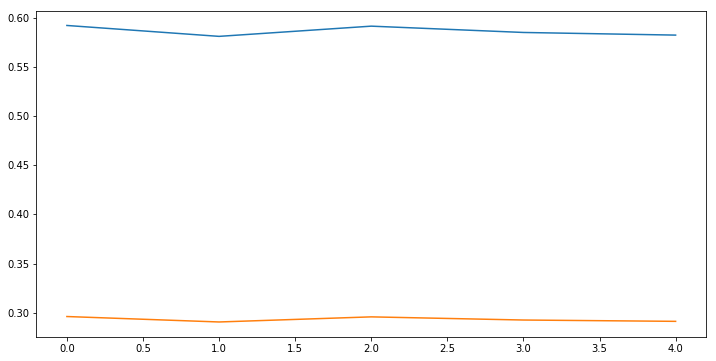

MSE Train:  0.20624293
MSE Test:  0.2183663


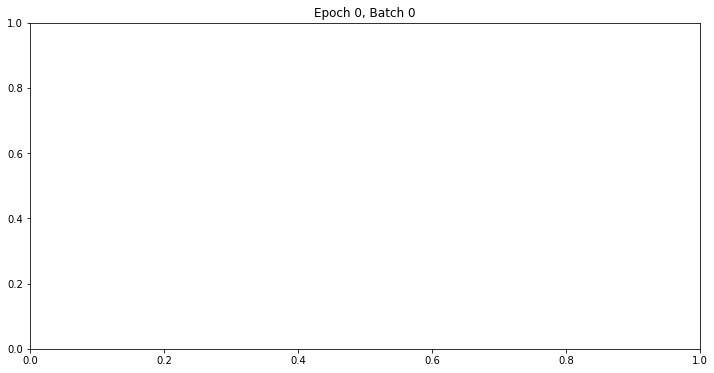

MSE Train:  0.0061818496
MSE Test:  0.0009333724


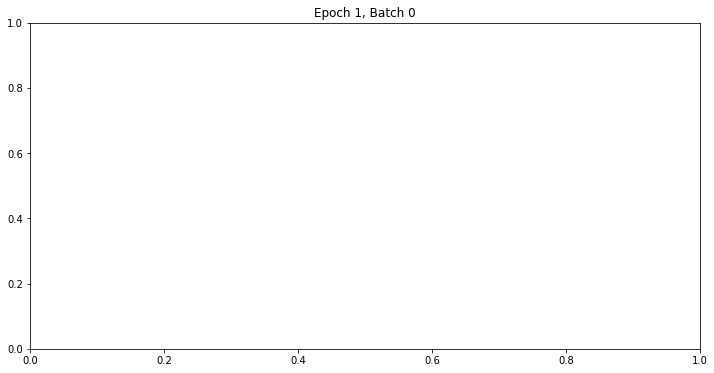

MSE Train:  0.0049003824
MSE Test:  0.00045700223


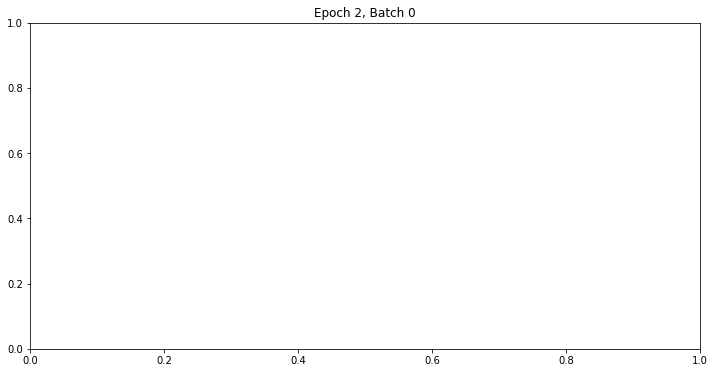

MSE Train:  0.005266481
MSE Test:  0.0040754536


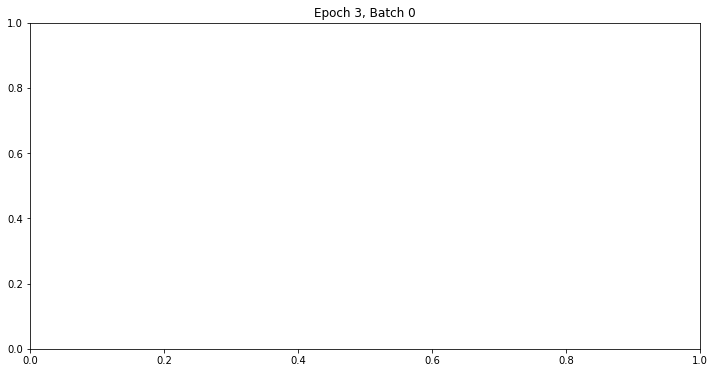

MSE Train:  0.002764942
MSE Test:  0.00028748353


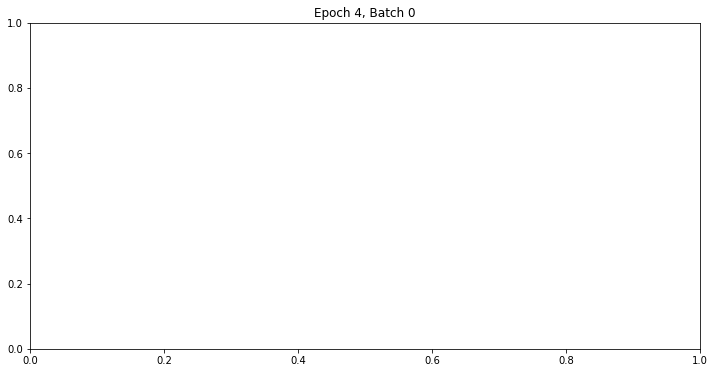

MSE Train:  0.0026937765
MSE Test:  7.226547e-05


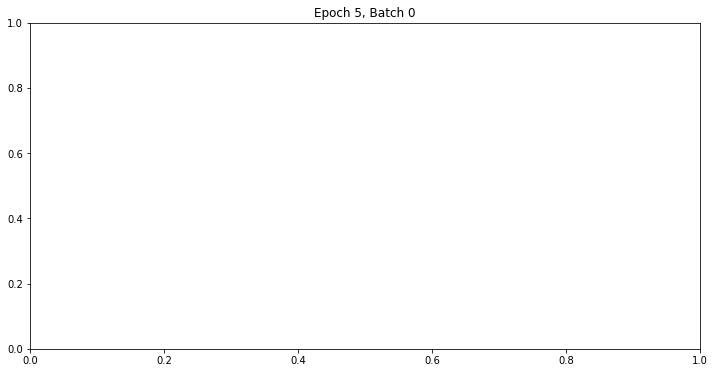

MSE Train:  0.0025127663
MSE Test:  7.383934e-05


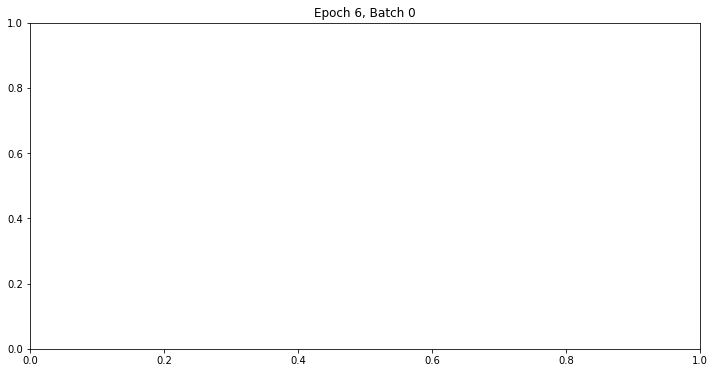

MSE Train:  0.0024820813
MSE Test:  7.247827e-05


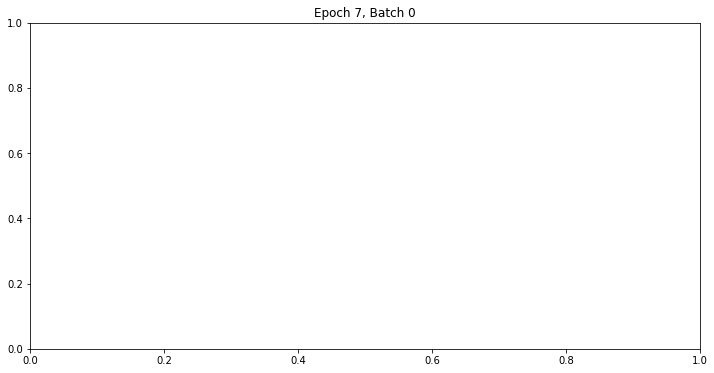

MSE Train:  0.0021672188
MSE Test:  0.000119212316


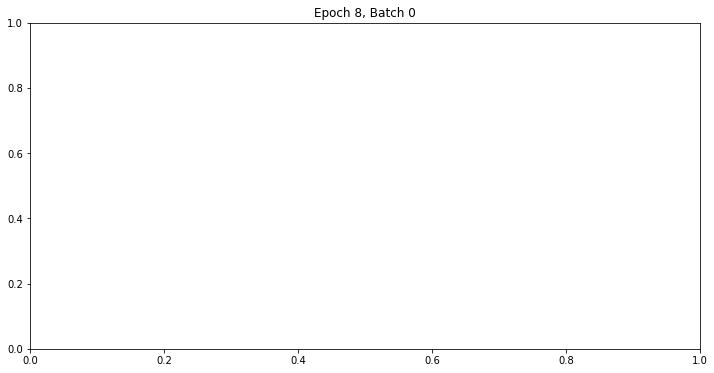

MSE Train:  0.002097545
MSE Test:  0.000119164564


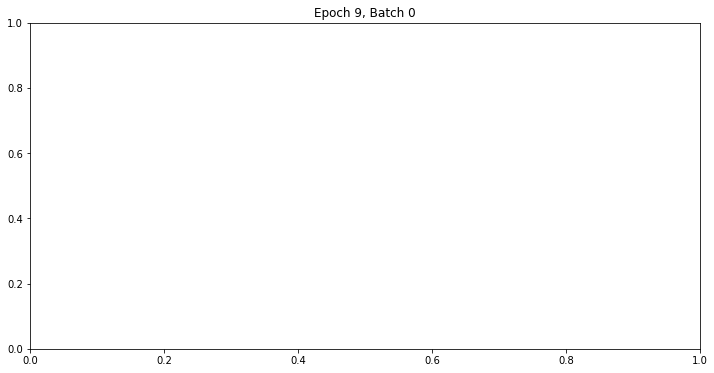

In [80]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())

# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

# Run
epochs = 10
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            plt.pause(0.01)

In [81]:
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)

0.0003900617


In [ ]:
def evaluate_arima_model(X, sarima_order, seas_order):
    # prepare training dataset
    trn = X[:'2019-11-15']
    tst = X['2019-11-18':'2019-11-22']

    model = sm.tsa.SARIMAX(trn, order=sarima_order, seasonal_order=seas_order).fit(full_output=True , disp=0)
    pred = model.predict(len(nal)-5, len(nal)-1)
    
    error = mean_squared_error(tst, pred)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for S in S_values:
                                order = (p,d,q)
                                seas_order = (P,D,Q,S)
                                try:
                                    mse = evaluate_arima_model(dataset, order, seas_order)
                                    if mse < best_score:
                                        best_score, best_cfg = mse, order
                                    print('SARIMA%s MSE=%.3f' % (order,seas_order,mse))
                                except:
                                    continue
    print('Best SARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = [4,5,6,7,8,9]
d_values = [0,1,2]
q_values = [4,5,6,7,8,9]
P_values = [0,1,2,3,4]
D_values = [0,1]
Q_values = [0,1,2,3,4]
S_values = [0,1]
warnings.filterwarnings("ignore")
evaluate_models(nal, p_values, d_values, q_values, P_values, D_values, Q_values, S_values)